In [1]:
# nltk is one of the most useful libraries when it comes to nlp
!pip install nltk

In [2]:
# Set seeds for reproducibility
import numpy as np
import tensorflow as tf
import random

np.random.seed(256)
tf.random.set_seed(256)
random.seed(256)

import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
from wordcloud import WordCloud

# Preprocessing and evaluation
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
df = pd.read_csv('tripadvisor_hotel_reviews.csv')
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


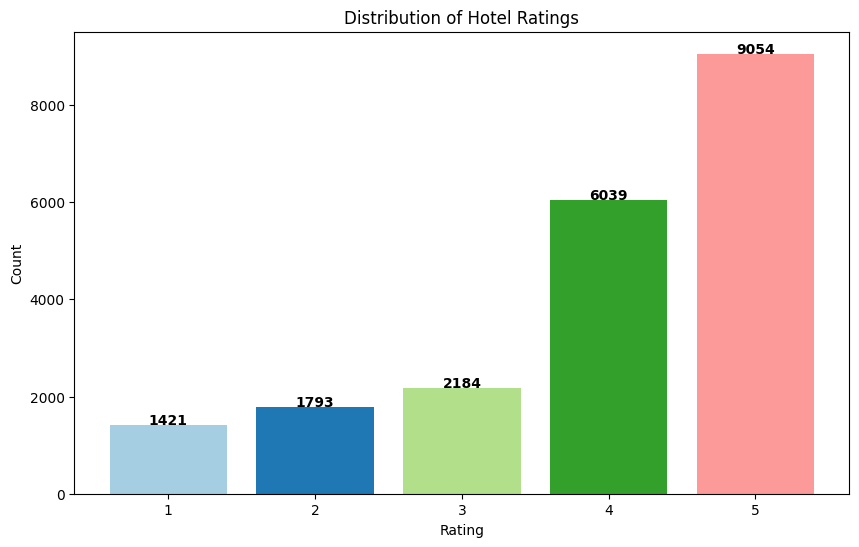

In [5]:

# Count the occurrences of each rating
rating_counts = df['Rating'].value_counts().sort_index()

# Define labels and sizes for the bar chart
labels = rating_counts.index.astype(str)
sizes = rating_counts.values
colors = plt.cm.Paired(range(len(labels)))

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(labels, sizes, color=colors)

# Add titles and labels
plt.title('Distribution of Hotel Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')

# Annotate the bars with the count values
for i, v in enumerate(sizes):
    plt.text(i, v + 10, str(v), ha='center', fontweight='bold')

plt.show()

In [6]:
# Length of word in sentence
df['Length'] = df['Review'].apply(len)
df.head()


,Review,Rating,Length
0,nice hotel expensive parking got good deal sta...,4,593
1,ok nothing special charge diamond member hilto...,2,1689
2,nice rooms not 4* experience hotel monaco seat...,3,1427
3,"unique, great stay, wonderful time hotel monac...",5,600
4,"great stay great stay, went seahawk game aweso...",5,1281


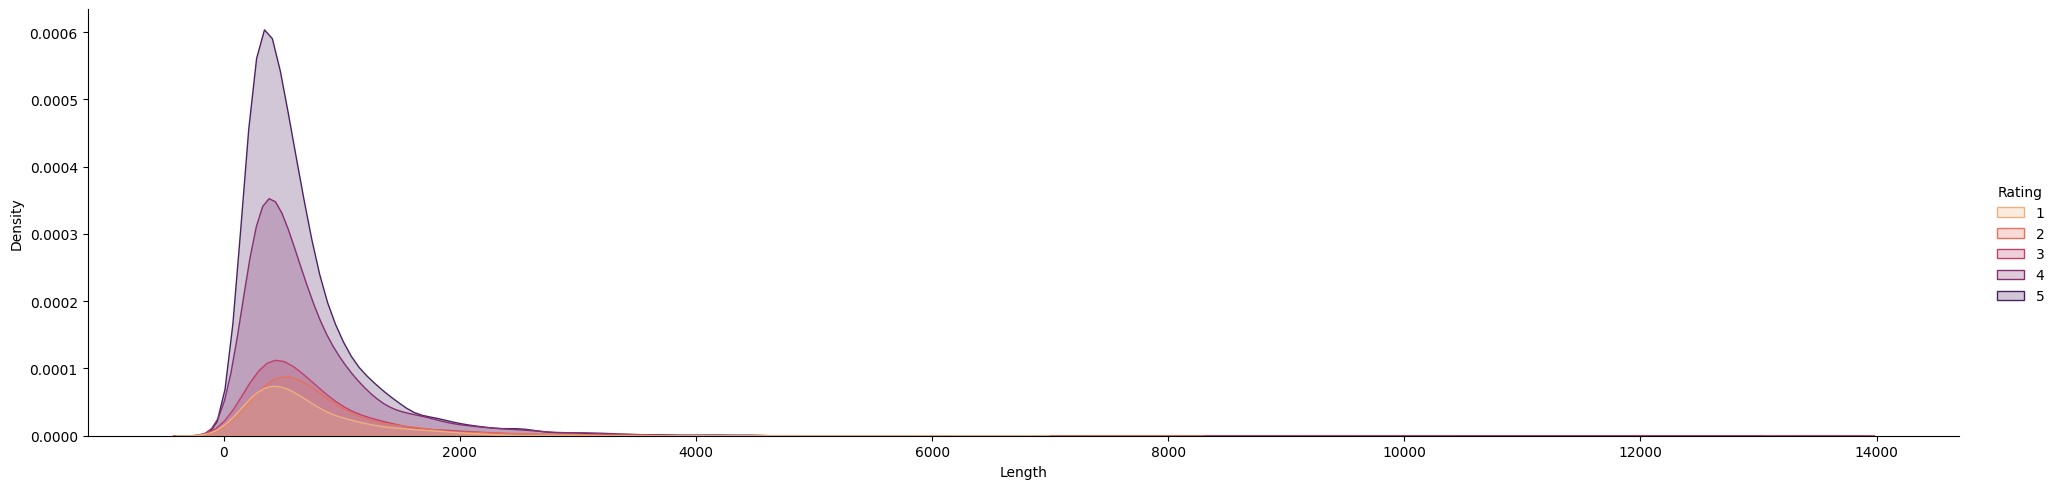

In [7]:
sns.displot(data=df, x='Length', hue='Rating', palette='flare', kind='kde', fill=True, aspect=4)

In [8]:
# Changing the rating to be more general and easier to understand
def rating(score):
    if score > 3:
        return 'Good'
    elif score == 3:
        return 'Neutral'
    else:
        return 'Bad'

df['Rating'] = df['Rating'].apply(rating)

df['Rating'].value_counts()

,count
Rating,
Good,15093
Bad,3214
Neutral,2184


In [9]:
# Preprocessing and evaluation
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [10]:
# Let's clean the text using stopwords
stop = set(stopwords.words('english'))
punctuation = string.punctuation
stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()

def cleaning(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in punctuation])
    words = text.split()
    words = [word for word in words if word not in stop]
    words = [stemmer.stem(word) for word in words]
    words = [lemmatizer.lemmatize(word) for word in words]
    clean_text = ' '.join(words)

    return clean_text

df['Cleaned_Review'] = df['Review'].apply(cleaning)

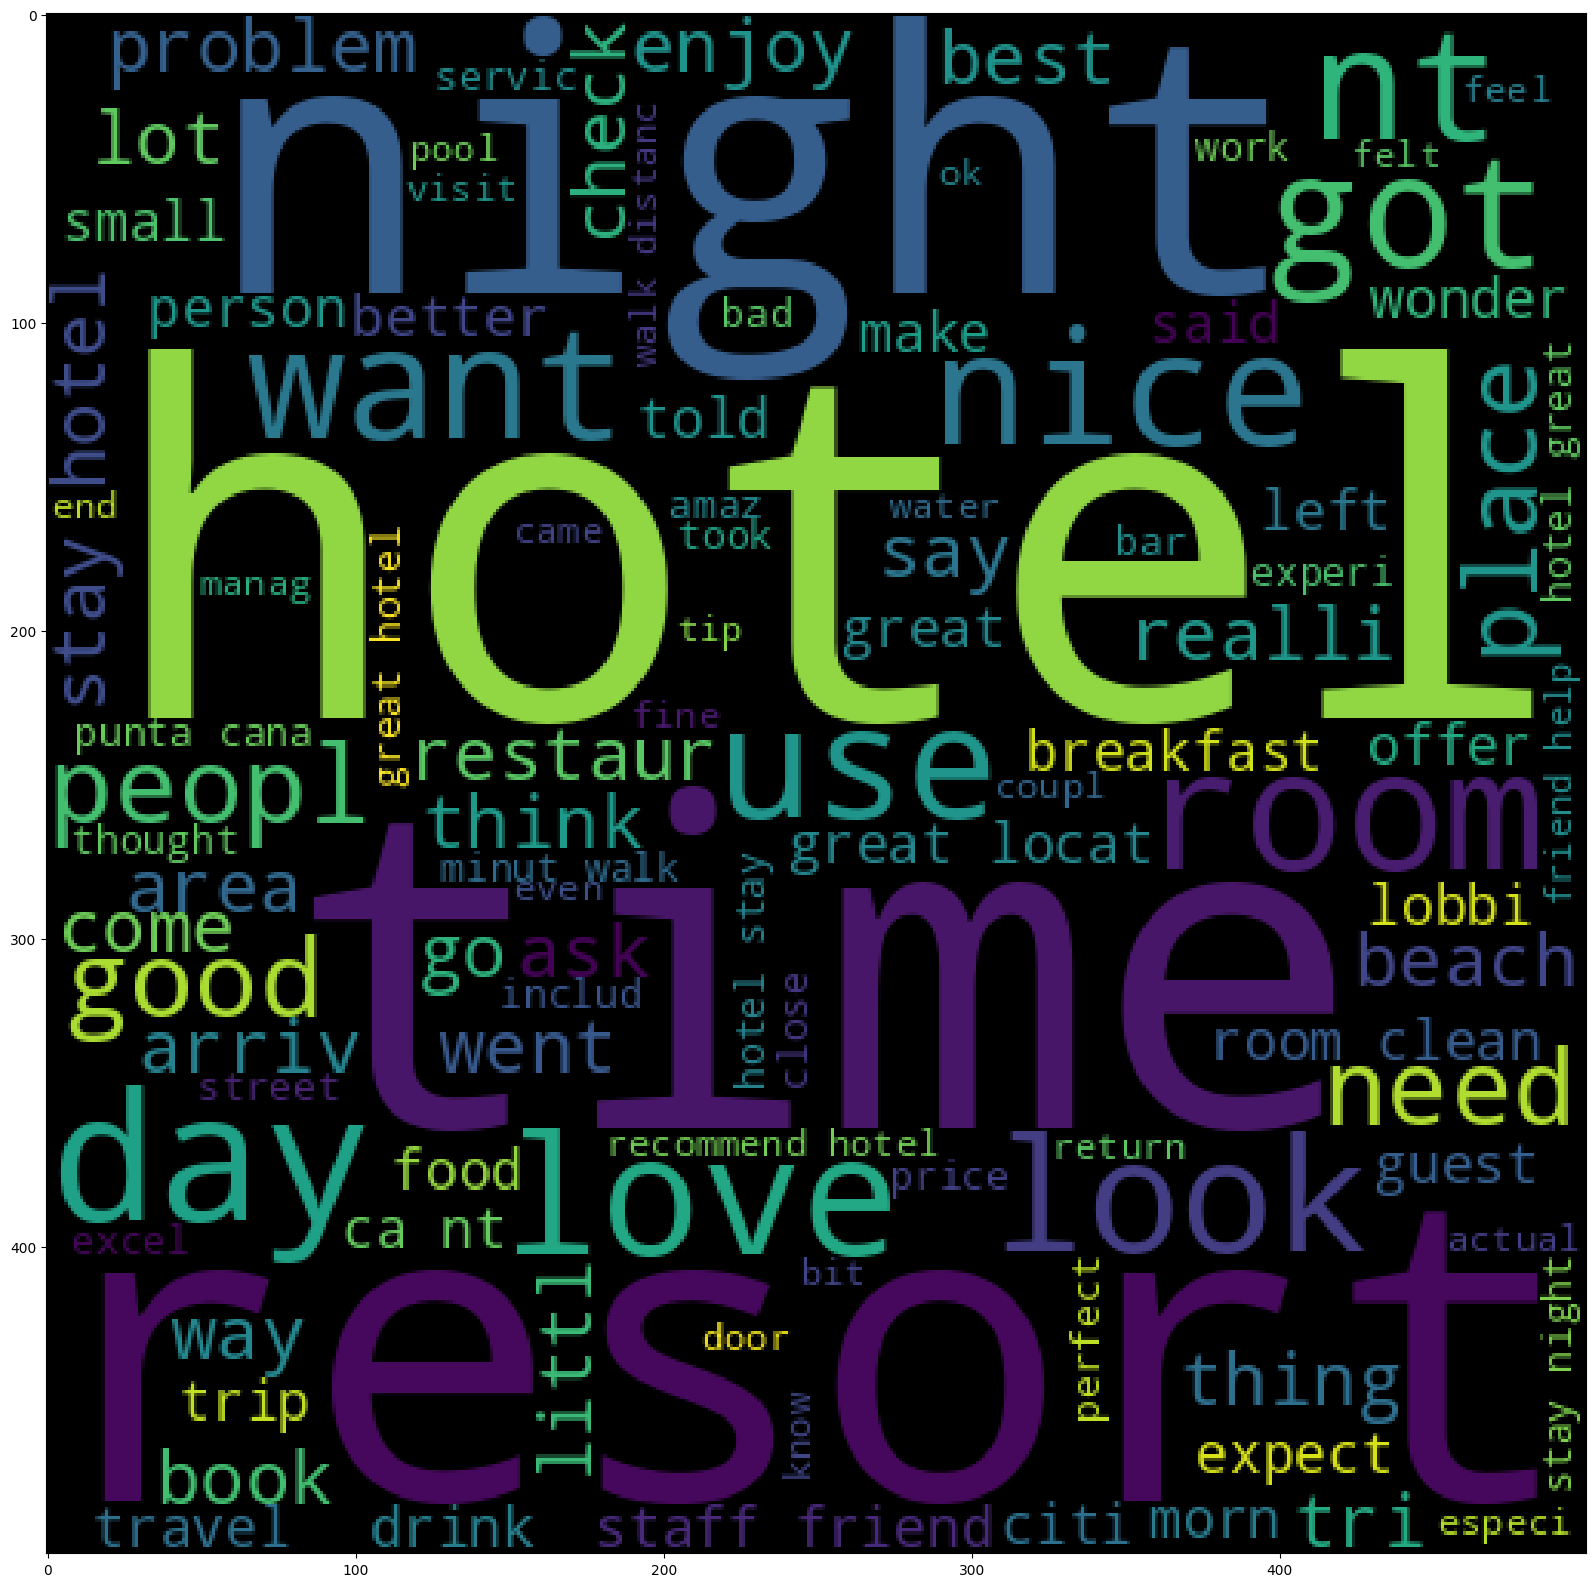

In [11]:
# Word cloud for cleaned text
plt.figure(figsize=(20, 20))
wc = WordCloud(width=500, height=500, min_font_size=10, background_color='black')
text = df['Cleaned_Review'].values
wc.generate(' '.join(text))
plt.imshow(wc)
plt.show()


In [12]:
# Text to sequence
tfid = TfidfVectorizer()
X = tfid.fit_transform(df['Cleaned_Review']).toarray()
X.shape

lb = LabelBinarizer()
y = lb.fit_transform(df['Rating'])

In [13]:
# Train test split for LSTM model
train_reviews, test_reviews, train_labels, test_labels = train_test_split(df['Cleaned_Review'], df['Rating'], test_size=0.3, random_state=1)

In [14]:
# Tokenizing and padding sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_reviews)
vocab_size = len(tokenizer.word_index) + 1

train_sequences = tokenizer.texts_to_sequences(train_reviews)
test_sequences = tokenizer.texts_to_sequences(test_reviews)

max_length = 100
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post')

train_labels = lb.transform(train_labels)
test_labels = lb.transform(test_labels)

In [15]:
# Deep learning model with LSTM
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 64, input_length=max_length),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(128, kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001), activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_padded, train_labels, epochs=10, validation_data=(test_padded, test_labels))




/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 113s 242ms/step - accuracy: 0.7175 - loss: 0.9441 - val_accuracy: 0.8305 - val_loss: 0.6077
Epoch 2/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 139s 236ms/step - accuracy: 0.8264 - loss: 0.5588 - val_accuracy: 0.8416 - val_loss: 0.4824
Epoch 3/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 107s 237ms/step - accuracy: 0.8545 - loss: 0.4384 - val_accuracy: 0.8284 - val_loss: 0.5072
Epoch 4/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 142s 238ms/step - accuracy: 0.8689 - loss: 0.3785 - val_accuracy: 0.8317 - val_loss: 0.5009
Epoch 5/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 106s 236ms/step - accuracy: 0.8930 - loss: 0.3192 - val_accuracy: 0.8286 - val_loss: 0.5529
Epoch 6/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 145s 244ms/step - accuracy: 0.9228 - loss: 0.2689 - val_accuracy: 0.8237 - val_loss: 0.6592
Epoch 7/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 139s 238ms/step - accuracy: 0.9345 - loss: 0.2335 - val_accuracy: 0.8126 - val_loss: 0.6796
Epoch 8/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 141s 236ms/step - accuracy: 0.9429 -

193/193 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step
[[ 588   87  294]
 [  83 3926  539]
 [ 107  254  270]]
              precision    recall  f1-score   support

           0       0.76      0.61      0.67       969
           1       0.92      0.86      0.89      4548
           2       0.24      0.43      0.31       631

    accuracy                           0.78      6148
   macro avg       0.64      0.63      0.63      6148
weighted avg       0.82      0.78      0.80      6148



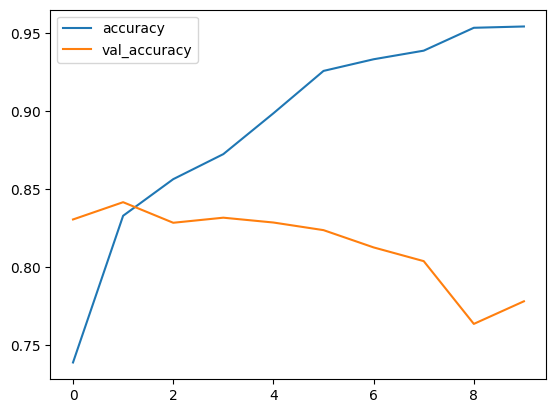

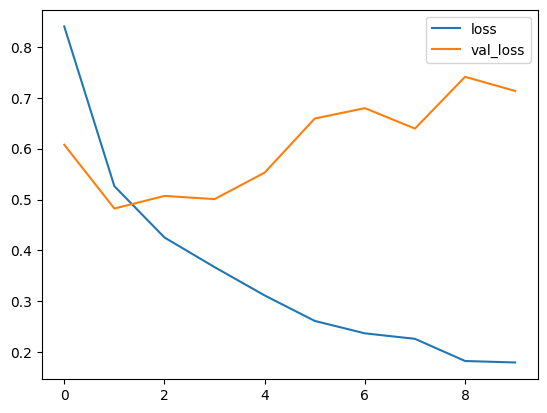

In [16]:
from sklearn.metrics import confusion_matrix, classification_report 

metrics = pd.DataFrame(model.history.history)
metrics[['accuracy', 'val_accuracy']].plot()
metrics[['loss', 'val_loss']].plot()

pred2 = model.predict(test_padded)

true_labels = np.argmax(test_labels, axis=-1)
pred_labels = np.argmax(pred2, axis=-1)

print(confusion_matrix(true_labels, pred_labels))
print(classification_report(true_labels, pred_labels))

              precision    recall  f1-score   support

           0       0.76      0.61      0.67       969
           1       0.92      0.86      0.89      4548
           2       0.24      0.43      0.31       631

    accuracy                           0.78      6148
   macro avg       0.64      0.63      0.63      6148
weighted avg       0.82      0.78      0.80      6148



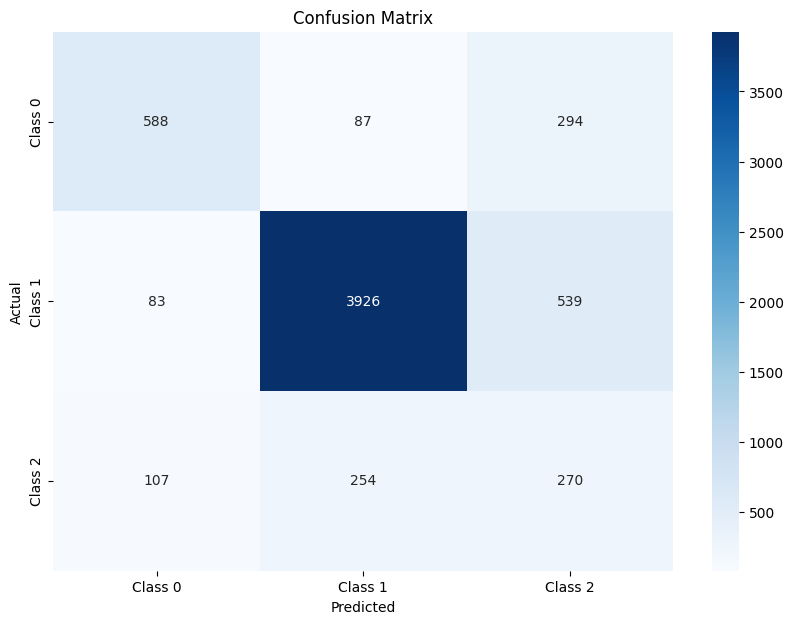

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Print classification report
print(classification_report(true_labels, pred_labels))

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1', 'Class 2'],  
            yticklabels=['Class 0', 'Class 1', 'Class 2']) 
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [19]:
model.save('lstm_model.h5')

In [25]:
# LSTM prediction
def dl_predict(text):
    clean_text = cleaning(text)
    seq = tokenizer.texts_to_sequences([clean_text])
    padded = pad_sequences(seq, maxlen=max_length)

    pred = model.predict(padded)
    # Get the label name back
    result = lb.inverse_transform(pred)[0]

    return result

text = 'Such a comfy place to stay with the loved one'
print('Prediction using LSTM: {}'.format(dl_predict(text)))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Prediction using LSTM: Neutral
